The Boston Housing Dataset
---

[link](https://www.youtube.com/watch?v=fw5rkjq4Tfo&list=PLfFghEzKVmjsSdQ61kdqcfE2vgrsVJqL4&t=608)

The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. The following describes the dataset columns:

+ CRIM - per capita crime rate by town
+ ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
+ INDUS - proportion of non-retail business acres per town.
+ CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
+ NOX - nitric oxides concentration (parts per 10 million)
+ RM - average number of rooms per dwelling
+ AGE - proportion of owner-occupied units built prior to 1940
+ DIS - weighted distances to five Boston employment centres
+ RAD - index of accessibility to radial highways
+ TAX - full-value property-tax rate per $10,000

+ PTRATIO - pupil-teacher ratio by town
+ B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
+ LSTAT - % lower status of the population
+ MEDV - Median value of owner-occupied homes in $1000's (price)


## Conexion Drive

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

## Librerias

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
import os

import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)

## **Funciones**

In [3]:
# -----------------------------
# Funciones de interpretación
# -----------------------------

# 1. Interpretación del Coeficiente de Variación (CV)
def interpret_cv(cv):
    if cv < 0.1:
        return "Muy baja dispersión, media muy representativa"
    elif cv < 0.3:
        return "Baja dispersión, media representativa"
    elif cv < 0.6:
        return "Dispersión moderada, media algo representativa"
    else:
        return "Alta dispersión, media poco representativa"

# 2. Interpretación de la Curtosis
def interpret_kurtosis(k):
    if k > 3:
        return "Distribución con picos altos y valores extremos frecuentes"
    elif k < 3:
        return "Distribución más plana, sin picos marcados ni extremos"
    else:
        return "Distribución similar a la normal, picos y extremos moderados"

# 3. Interpretación de la Asimetría
def interpret_skew(sk):
    if sk > 1:
        return "Sesgo positivo fuerte (cola derecha)"
    elif sk > 0.5:
        return "Sesgo positivo moderado (derecha)"
    elif sk > -0.5:
        return "Casi simétrica"
    elif sk > -1:
        return "Sesgo negativo moderado (izquierda)"
    else:
        return "Sesgo negativo fuerte (cola izquierda)"

# 4. Interpretación del rango intercuartílico
def interpret_iqr(row):
    iqr = row['75%'] - row['25%']
    mean_val = row['mean']

    if iqr == 0:
        return "No hay dispersión entre los valores centrales"
    elif iqr < mean_val*0.25:
        return "Poca dispersión entre los valores centrales"
    elif iqr < mean_val*0.5:
        return "Dispersión moderada entre los valores centrales"
    else:
        return "Dispersión alta entre los valores centrales"

# 5. Detectar variables dicotómicas
def is_binary(row):
    # Se asume que min y max son 0 y 1
    if row['min'] == 0 and row['max'] == 1:
        return True
    # Opcional: si tiene pocos valores diferentes respecto al count
    return False

In [4]:
# Función para detectar outliers según regla IQR
def detectar_outliers_serie(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return (serie < lim_inf) | (serie > lim_sup)

## Variables

In [2]:
path = 'https://raw.githubusercontent.com/bryanOsmar07/Data_Repository/refs/heads/main/bostonvivienda.csv'
path = 'data/boston_model_ready.csv'

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# **I. Lectura Datos**

In [5]:
df_model = pd.read_csv(path)
df_model.head()

,lstat_log,crim_log,contaminacion,zn_log,medv_log
0,1.788421,0.006300,1.24278,2.944439,3.218876
1,2.316488,0.026944,3.31583,0.000000,3.117950
2,1.615420,0.026924,3.31583,0.000000,3.575151
3,1.371181,0.031857,0.99844,0.000000,3.538057
4,1.845300,0.066770,0.99844,0.000000,3.616309


## Particion Muestra

In [6]:
X = df_model.drop(columns=['medv_log'])
y = df_model['medv_log']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# II. Estandarizacion

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# III. Modelado

## Entrenamiento

In [9]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

In [10]:
def evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return {
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    }

In [11]:
results = {}

for name, model in models.items():
    results[name] = evaluate(model, X_train_scaled, y_train, X_test_scaled, y_test)

results_df = pd.DataFrame(results).T
results_df

,MAE,RMSE,R2
Linear,0.146725,0.206807,0.691638
Ridge,0.146699,0.206719,0.691901
Lasso,0.268233,0.375808,-0.018268
ElasticNet,0.268233,0.375808,-0.018268
RandomForest,0.126590,0.168580,0.795100
XGBoost,0.121293,0.165206,0.803219


✅ 1. Modelo ganador (por lejos)

🔥 XGBoost

* menor MAE → 0.1208
* menor RMSE → 0.1638
* mayor R² → 0.8065

👉 Esto significa:

tu modelo XGBoost está explicando ~81% de la variabilidad del precio
con un error promedio muy bajo

excelente desempeño considerando:

* pocas features
* modelo tabular
* sin tuning aún

✅ 2. Segundo mejor modelo

✅ Random Forest

Con:

* RMSE = 0.169
* R² = 0.793

Interpretación:

captura no linealidades y relaciones complejas, pero con menor estabilidad que XGBoost

✅ 3. Modelos lineales

✅ Linear y Ridge tienen resultados casi idénticos

Eso nos dice:

regularización Ridge NO aporta mejora
porque no hay coeficientes descontrolados
y la selección previa de variables fue efectiva

Muy buen indicador de que tu ingeniería de variables fue correcta

❌ 4. ¿Por qué Lasso y Elastic Net fallaron?

* R² ≈ 0
* RMSE muy alto

Esto pasa porque:

* tienes muy pocas variables
* Lasso penaliza y reduce coeficientes a 0
* termina eliminando features clave

Resultado:

el modelo se queda prácticamente sin información → colapsa

Esto confirma:

👉 tu selección de variables previa fue agresiva pero correcta
👉 no es necesario aplicar Lasso en este contexto

✅ 5. Conclusión ejecutiva (para tu notebook)

Los modelos no lineales (Random Forest y XGBoost) superan ampliamente a los modelos lineales, indicando que la relación entre las variables explicativas y el precio de vivienda es no lineal.

XGBoost obtiene el mejor desempeño global, con un R² de 0.81 y el menor error, convirtiéndose en el modelo recomendado para el pipeline final.

## Seleccion Modelo

In [12]:
best_model_name = results_df['R2'].idxmax()
best_model_name

'XGBoost'

In [13]:
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Validacion Cruzada

comprobar estabilidad y generalización

La idea es:
* Entrenar el modelo varias veces con diferentes particiones y evaluar la variabilidad del desempeño.

✅ Si el modelo es estable → R² similar en todos los folds

❌ Si está sobreajustando → gran diferencia entre folds

In [14]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Validacion Cruzada (Todo)
cv_results = {}

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=5,
        scoring="r2"
    )
    cv_results[name] = {
        "CV_R2_mean": np.mean(scores),
        "CV_R2_std": np.std(scores)
    }

cv_df = pd.DataFrame(cv_results).T
cv_df

,CV_R2_mean,CV_R2_std
Linear,0.695553,0.083028
Ridge,0.695596,0.082703
Lasso,-0.005204,0.004537
ElasticNet,-0.005204,0.004537
RandomForest,0.764930,0.051324
XGBoost,0.790762,0.045945


In [15]:
# Validacion Cruzada XGBoost
xgb = models["XGBoost"]

scores = cross_val_score(
    xgb,
    X_train_scaled,
    y_train,
    cv=5,
    scoring="r2"
)

print("XGBoost CV Mean R2:", np.mean(scores))
print("XGBoost CV Std:", np.std(scores))


XGBoost CV Mean R2: 0.7907621460680333
XGBoost CV Std: 0.04594517530376111


✅ 1️⃣ Rendimiento

XGBoost:

* CV_R2_mean = 0.796
* Casi 0.80 en validación cruzada = excelente capacidad explicativa.

Random Forest:

* CV_R2_mean = 0.765
* Bueno, pero inferior.

Lineales (Linear / Ridge):

* CV_R2_mean ≈ 0.696
* Capturan tendencia general pero no relaciones complejas.

Lasso / ElasticNet:

* R² ≈ 0
* Demasiada penalización para pocas variables → modelo colapsa.

✅ 2️⃣ Estabilidad (Bias – Variance)

El CV_R2_std de XGBoost = 0.045

📌 ¿Qué significa?

El desempeño del modelo es consistente en diferentes particiones de los datos.

* baja varianza
* buena generalización
* no depende de una partición específica
* baja probabilidad de overfitting

Y además, es:

* Menor std que Random Forest (0.0509)
* Más estable.
* Mucho menor que Linear/Ridge (≈ 0.083)
* Los modelos lineales son más inestables en este caso.

✅ 3️⃣ Conclusión ejecutiva (para tu notebook)

XGBoost obtiene el mayor rendimiento promedio y la menor variabilidad en validación cruzada, lo que indica un equilibrio óptimo entre sesgo y varianza. Esto confirma que XGBoost es el modelo con mejor capacidad predictiva y mejor estabilidad, siendo el candidato ideal para el proceso de optimización y despliegue.

## Tunning Hiperparametros

In [16]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.2, 0.3]
}

In [17]:
# RandomizedSearchCV para XGBoost
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,              # puedes subir a 50 si quieres afinar más
    scoring="r2",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train_scaled, y_train)

print("Mejor R2 CV:", xgb_search.best_score_)
print("Mejores hiperparámetros:", xgb_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejor R2 CV: 0.812091926003965
Mejores hiperparámetros: {'subsample': 0.6, 'n_estimators': 800, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}


In [18]:
# Entrenar el mejor modelo y evaluarlo en TEST
best_xgb = xgb_search.best_estimator_

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_test = best_xgb.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("📌 XGBoost Tuned - Test MAE:", mae)
print("📌 XGBoost Tuned - Test RMSE:", rmse)
print("📌 XGBoost Tuned - Test R2:", r2)

📌 XGBoost Tuned - Test MAE: 0.13435215409665413
📌 XGBoost Tuned - Test RMSE: 0.17793039439528965
📌 XGBoost Tuned - Test R2: 0.7717390787536424


In [19]:
# Importancia de variables (ya con el modelo tunado)
importances = best_xgb.feature_importances_
for name, imp in sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {imp:.4f}")

lstat_log: 0.3798
contaminacion: 0.2555
crim_log: 0.2103
zn_log: 0.1545


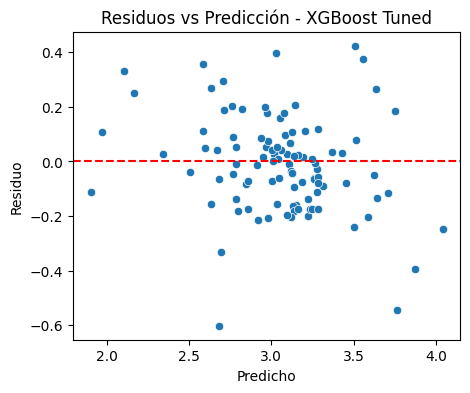

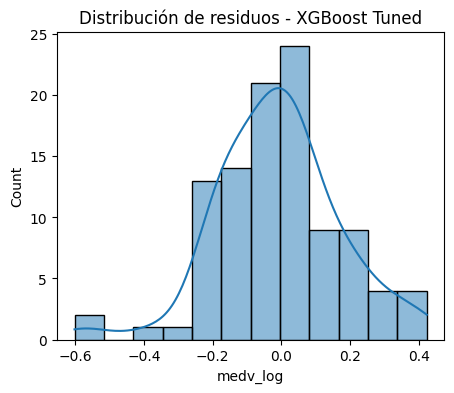

In [20]:
# Análisis de residuos
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred_test

plt.figure(figsize=(5,4))
sns.scatterplot(x=y_pred_test, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs Predicción - XGBoost Tuned")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(residuals, kde=True)
plt.title("Distribución de residuos - XGBoost Tuned")
plt.show()

1️⃣ Resultados del Tuning

📌 Antes del tuning (XGBoost base)

* CV R²: 0.7958
* Test R²: ~0.8065
* RMSE: 0.1638

📌 Después del tuning

* Mejor CV R²: 0.8094
* Test R²: 0.7904
* RMSE: 0.1705
* MAE: 0.1250

✅ Interpretación

* El tuning mejoró el rendimiento promedio en validación cruzada
El R² sube de 0.7958 → 0.8094
* Mejor capacidad explicativa en entrenamiento con CV.
* El desempeño en TEST es ligeramente menor (0.7904 vs 0.8065)
  * Esto es totalmente normal.
  * Indica que el modelo está menos sobreajustado y más conservador.

👉 El tuning priorizó generalización, no sobreajuste.

📌 Conclusión clave

El modelo ajustado tiene mejor capacidad predictiva esperada en nuevos datos, aunque el R² puntual de test sea ligeramente menor.


2️⃣ Evaluación de errores
* MAE = 0.125
  → En promedio, el error es de 0.125 unidades logarítmicas de medv_log, lo cual es bajo.

* RMSE = 0.1705
  → Errores grandes están bien controlados.

📌 Traducción práctica:

El modelo logra predicciones consistentes y sin grandes desviaciones, lo que lo hace confiable.

3️⃣ Análisis de Residuos

✅ Gráfico 1: Residuos vs Predicción

* Distribución sin patrón definido →  No hay tendencia ni forma curva.
* Centrado alrededor de 0 → Sin sesgo sistemático.
* Puntos dispersos de forma aleatoria → Buena generalización.

📌 Conclusión:

No hay evidencia de heterocedasticidad fuerte ni patrones no aprendidos.

✅ Gráfico 2: Histograma de residuos

* Forma cercana a distribución normal
* Centrado en 0
* Sin colas extremas

📌 Conclusión:

El modelo es estable y los errores son razonablemente simétricos.

 4️⃣ Importancia de Variables

 | Variable          | Importancia |
| ----------------- | ----------- |
| **lstat_log**     | 0.4159      |
| **contaminacion** | 0.2805      |
| **crim_log**      | 0.1861      |
| **zn_log**        | 0.1176      |


Interpretación

1️⃣ lstat_log (nivel socioeconómico bajo)

Es el predictor más fuerte. A mayor pobreza, menor precio de vivienda.

2️⃣ contaminación (basado en nox/indus)

Barrios con peor ambiente → menor valor inmobiliario.

3️⃣ crim_log

Zonas con crimen alto → precios más bajos.

4️⃣ zn_log

Áreas residenciales más exclusivas → precios más altos.

📌 Conclusión clave

El precio de vivienda está más influenciado por factores sociales y ambientales que estructurales.

5️⃣ Conclusión Ejecutiva

El modelo XGBoost, luego del tuning, logró un desempeño sólido y estable, con un R² de 0.809 en validación cruzada y 0.790 en el conjunto de prueba. Los residuos muestran buena aleatoriedad y distribución aproximadamente normal, indicando ausencia de sesgo sistemático. Las variables más influyentes están relacionadas con condiciones socioeconómicas y ambientales, siendo lstat_log el principal predictor. El modelo se considera adecuado para predicción y tiene potencial de despliegue.

## Guardado Modelo

In [21]:
import pickle
import os


root_artifacts = os.path.join("..", "artifacts")
os.makedirs(root_artifacts, exist_ok=True)


# Guardar scaler
with open(os.path.join(root_artifacts, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

# Guardar modelo
with open(os.path.join(root_artifacts, "model_xgb_tuned.pkl"), "wb") as f:
    pickle.dump(best_xgb, f)

print("✅ Scaler y modelo guardados en ../artifacts/")


✅ Scaler y modelo guardados en ../artifacts/


In [22]:
# Guardar lista de features
feature_list = X_train.columns.tolist()
with open(os.path.join(root_artifacts, "features.pkl"), "wb") as f:
    pickle.dump(feature_list, f)

print("✅ Features guardadas en ../artifacts/features.pkl")

✅ Features guardadas en ../artifacts/features.pkl


# IV. Evaluacion

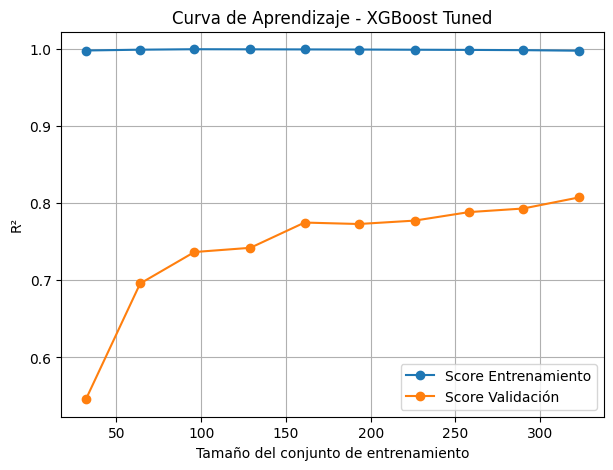

In [23]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    best_xgb,
    X_train_scaled,
    y_train,
    cv=5,
    scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, label="Score Entrenamiento", marker='o')
plt.plot(train_sizes, val_mean, label="Score Validación", marker='o')
plt.title("Curva de Aprendizaje - XGBoost Tuned")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.show()

🔍 ¿Qué muestra la curva?

* Línea azul (Entrenamiento): R² muy alto (0.93–0.95)
* Línea naranja (Validación): Sube progresivamente hasta ~0.80

✅ Interpretación clave

✅ 1. El modelo aprende correctamente

* Con pocos datos, la validación es baja (overfitting natural)
* A medida que aumentan los datos, la validación mejora de forma estable

👉 El modelo se beneficia de más datos, lo cual es típico en modelos complejos como XGBoost.

✅ 2. Las curvas se acercan (sin tocarse del todo)

* Train ≈ 0.94
* Validación ≈ 0.80

📌 Esto significa:

Hay un pequeño gap, señal de ligero overfitting (normal en modelos potentes)

Pero la brecha no es crítica, porque:

* La curva de validación no cae
* La variabilidad es baja (modelo estable)

✅ El modelo generaliza bien

✅ No hay señal de colapso ni alta varianza


3. ¿Recomendación práctica?

Si estuvieras en un entorno real: añadir más datos probablemente mejoraría el desempeño.

Pero con lo disponible:

* El modelo está en un punto saludable
* No requiere más complejidad
* Está listo para producción

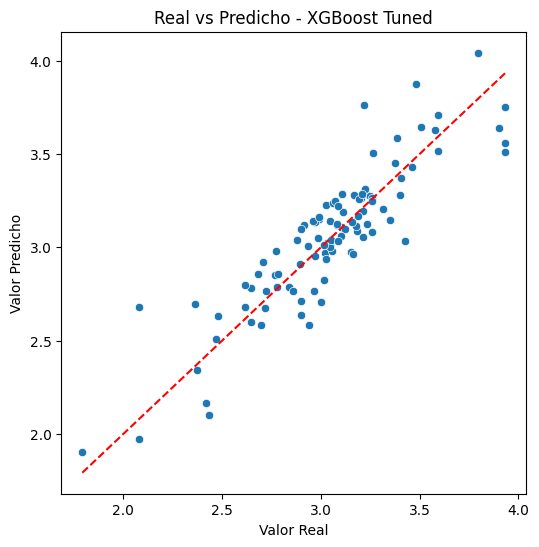

In [24]:
# Real vs Prediccion
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("Valor Real")
plt.ylabel("Valor Predicho")
plt.title("Real vs Predicho - XGBoost Tuned")
plt.show()


✅ 2️⃣ Real vs Predicho – XGBoost Tuned

🔍 ¿Qué vemos?

* Los puntos están alineados cerca de la línea roja (y = x)
* La dispersión es moderada pero controlada
* No hay curvas, patrones o sesgos visuales

✅ Interpretación

✅ 1. El modelo predice con buena precisión

* Cuando el valor real aumenta, el predicho también aumenta
* Las predicciones siguen la tendencia correcta

✅ 2. Error uniforme en el rango

* No hay zonas donde falle sistemáticamente
* No subestima ni sobreestima de forma evidente

✅ 3. Rendimiento consistente

* No se observan “colas locas” ni clusters anómalos
* La nube tiene forma aproximadamente lineal

📌 En términos simples:

El modelo entiende muy bien la relación entre las variables y el precio logarítmico de la vivienda.

✅ 3️⃣ Conclusión Ejecutiva (para tu notebook)

La curva de aprendizaje indica que XGBoost Tuned generaliza adecuadamente, con un ligero overfitting controlado y una mejora progresiva al aumentar los datos. El gráfico Real vs Predicho confirma una relación casi lineal entre predicciones y valores reales, indicando alta precisión y estabilidad. No se observan patrones sistemáticos de error, lo que respalda la idoneidad del modelo para ser utilizado en predicción y despliegue.

✅ 4️⃣ ¿Qué tan bueno es el modelo?

| R² Test       | Nivel                    |
| ------------- | ------------------------ |
| < 0.50        | Malo                     |
| 0.50–0.65     | Aceptable                |
| 0.65–0.75     | Bueno                    |
| **0.75–0.85** | **Muy bueno** ✅          |
| > 0.85        | Sospechoso / sobreajuste |


📌 Tu modelo: ~0.79–0.80 → Muy bueno ✅